In [59]:
import pandas as pd
import numpy as np
import gensim
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
tqdm.pandas(desc="progress-bar")

data = pd.read_csv("labeledTrainData.tsv", delimiter = '\t', quoting=3)

In [60]:
data.shape

(25000, 3)

In [61]:
data.columns.values

array(['id', 'sentiment', 'review'], dtype=object)

In [71]:
data["review"][1]

'"\\"The Classic War of the Worlds\\" by Timothy Hines is a very entertaining film that obviously goes to great effort and lengths to faithfully recreate H. G. Wells\' classic book. Mr. Hines succeeds in doing so. I, and those who watched his film with me, appreciated the fact that it was not the standard, predictable Hollywood fare that comes out every year, e.g. the Spielberg version with Tom Cruise that had only the slightest resemblance to the book. Obviously, everyone looks for different things in a movie. Those who envision themselves as amateur \\"critics\\" look only to criticize everything they can. Others rate a movie on more important bases,like being entertained, which is why most people never agree with the \\"critics\\". We enjoyed the effort Mr. Hines put into being faithful to H.G. Wells\' classic novel, and we found it to be very entertaining. This made it easy to overlook what the \\"critics\\" perceive to be its shortcomings."'

In [53]:
# Tokenizing the data

tokens = []
for i in range(0,len(data)):
    temp = []
    temp.append(gensim.utils.simple_preprocess(data["review"][i]))
    temp.append(data["sentiment"][i])
    tokens.append(temp)

In [54]:
# Test/train split

from sklearn.model_selection import train_test_split
train, test = train_test_split(tokens, test_size=0.2)

In [55]:
# Training W2V space

size = 60
model = gensim.models.Word2Vec ([row[0] for row in tokens], size=size, window=7, min_count=10, workers=10)
model.train([row[0] for row in tqdm(tokens)],total_examples=len([row[0] for row in tokens]),epochs=10)

100%|███████████████████████████████████████████████████████████████████████| 25000/25000 [00:00<00:00, 2278670.93it/s]


(41713178, 56531940)

In [56]:
# In order to use a CNN we'll need uniform review length. Let's see if there is a large gap
# between the longest and the shortest review.

# Min review length
l = 10000
for i in range(0,len(tokens)):
    if len(tokens[i][0]) < l:
        l = len(tokens[i][0])

print("Min length: ",l)

l = 0
for i in range(0,len(tokens)):
    if len(tokens[i][0]) > l:
        l = len(tokens[i][0])

print("Max length: ",l)

Min length:  9
Max length:  2380


Mean:  226.37255


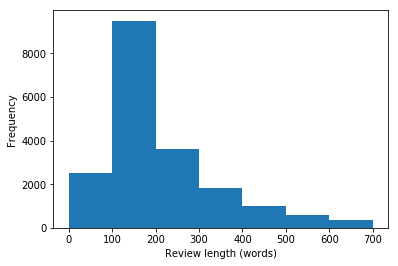

In [66]:
# That's a problem. Not really an option to cut to the shortest or PAD to the longest.
# Let's inspect the distribution of review length:

dist = []
for leng in train:
    dist.append(len(leng[0]))

mean = sum(dist) / len(dist)
print("Mean: ",mean)
plt.hist(dist,[0,100,200,300,400,500,600,700])
plt.xlabel("Review length (words)")
plt.ylabel("Frequency")
plt.show()

In [73]:
# Most of the data lies within the 100-400 words area. Let's choose a word count close 
# to the mean. We'll do this by cutting down reviews greater than, and "pad-ing" up those that
# are less
length = 300
for i in range(0,len(train)):
    if len(train[i][0]) < length:
        for j in range(0,length-len(train[i][0])):
            train[i][0].append("PAD")
    
    if len(train[i][0]) > length:
        train[i][0] = train[i][0][0:length]
        
for i in range(0,len(test)):
    if len(test[i][0]) < length:
        for j in range(0,length-len(test[i][0])):
            test[i][0].append("PAD")
    
    if len(test[i][0]) > length:
        test[i][0] = test[i][0][0:length]

Mean:  300.0


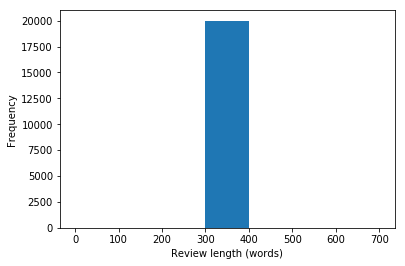

In [74]:
# Lets take a look at the distribution again

dist = []
for leng in train:
    dist.append(len(leng[0]))

mean = sum(dist) / len(dist)
print("Mean: ",mean)
plt.hist(dist,[0,100,200,300,400,500,600,700])
plt.xlabel("Review length (words)")
plt.ylabel("Frequency")
plt.show()

In [41]:
# Creating vectors of word representations for our reviews
trainVec = []
testVec = []
for i in range(0,len(train)):
    temp = []
    for j in range(0,len(train[i][0])):
        try:
            temp.append(model.wv[train[i][0][j]])
        except:
            temp.append([0]*size)
    trainVec.append(temp)

for i in range(0,len(test)):
    temp = []
    for j in range(0,len(test[i][0])):
        try:
            temp.append(model.wv[test[i][0][j]])
        except:
            temp.append([0]*size)
    testVec.append(temp)
    
trainVec = np.array(trainVec)
testVec = np.array(testVec)

In [42]:
# Creating the label vectors

trainLabel = []
testLabel = []

for i in range(0,len(train)):
    trainLabel.append(train[i][1])
    
for i in range(0,len(test)):
    testLabel.append(test[i][1])
    
trainLabel = np.array(trainLabel)
testLabel = np.array(testLabel)

In [43]:
from keras.models import Sequential
from keras.layers import Dense, Activation, MaxPooling2D
from keras.layers import Convolution2D, Flatten, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard

In [44]:
trainVec.shape

(20000, 300, 60)

In [45]:
# Reshape input arrays in order to be compattible with Keras' API

trainVec = trainVec.reshape((20000,length,size,1))
testVec = testVec.reshape((5000,length,size,1))

In [46]:
net = Sequential()
net.add(Convolution2D(64, 4,input_shape=(length,size,1), data_format='channels_last'))
# Convolutional model (3x conv, flatten, 2x dense)
net.add(Convolution2D(32,3, padding='same'))
net.add(Activation('relu'))
net.add(Convolution2D(16,2, padding='same'))
net.add(Activation('relu'))
net.add(Convolution2D(8,2, padding='same'))
net.add(Activation('relu'))
net.add(MaxPooling2D(pool_size=(3, 3)))

net.add(Flatten())
net.add(Dropout(0.2))
net.add(Dense(64,activation='sigmoid'))
net.add(Dropout(0.2))
net.add(Dense(1,activation='sigmoid'))
net.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

tensorBoardCallback = TensorBoard(log_dir='./logs', write_graph=True)
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 297, 57, 64)       1088      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 297, 57, 32)       18464     
_________________________________________________________________
activation_1 (Activation)    (None, 297, 57, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 297, 57, 16)       2064      
_________________________________________________________________
activation_2 (Activation)    (None, 297, 57, 16)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 297, 57, 8)        520       
_________________________________________________________________
activation_3 (Activation)    (None, 297, 57, 8)        0         
__________

In [47]:
print("Training model...")
model_info = net.fit(trainVec, trainLabel, epochs=3, callbacks=[tensorBoardCallback],
                     validation_data = (testVec, testLabel), batch_size=64,verbose=1)

Training model...
Train on 20000 samples, validate on 5000 samples
Epoch 1/3


12928/20000 [==================>...........] - ETA: 1:02:10 - loss: 1.0852 - acc: 0.37 - ETA: 47:54 - loss: 1.4314 - acc: 0.4062 - ETA: 40:35 - loss: 1.4694 - acc: 0.44 - ETA: 36:32 - loss: 1.4717 - acc: 0.47 - ETA: 34:14 - loss: 1.5010 - acc: 0.47 - ETA: 32:34 - loss: 1.4863 - acc: 0.47 - ETA: 31:22 - loss: 1.4650 - acc: 0.47 - ETA: 30:25 - loss: 1.4107 - acc: 0.47 - ETA: 29:38 - loss: 1.3468 - acc: 0.47 - ETA: 29:00 - loss: 1.2917 - acc: 0.47 - ETA: 28:32 - loss: 1.2459 - acc: 0.46 - ETA: 28:05 - loss: 1.2019 - acc: 0.47 - ETA: 27:42 - loss: 1.1723 - acc: 0.47 - ETA: 27:21 - loss: 1.1423 - acc: 0.47 - ETA: 26:59 - loss: 1.1160 - acc: 0.48 - ETA: 26:41 - loss: 1.0934 - acc: 0.48 - ETA: 26:24 - loss: 1.0701 - acc: 0.48 - ETA: 26:10 - loss: 1.0487 - acc: 0.49 - ETA: 25:56 - loss: 1.0317 - acc: 0.49 - ETA: 25:45 - loss: 1.0154 - acc: 0.50 - ETA: 25:31 - loss: 0.9995 - acc: 0.50 - ETA: 25:20 - loss: 0.9875 - acc: 0.50 - ETA: 25:09 - loss: 0.9762 - acc: 0.50 - ETA: 24:58 - loss: 0.9670 - a

13056/20000 [==================>...........] - ETA: 26:43 - loss: 0.5456 - acc: 0.73 - ETA: 25:26 - loss: 0.5764 - acc: 0.72 - ETA: 24:59 - loss: 0.5391 - acc: 0.72 - ETA: 24:42 - loss: 0.5464 - acc: 0.72 - ETA: 24:28 - loss: 0.5522 - acc: 0.72 - ETA: 24:18 - loss: 0.5449 - acc: 0.72 - ETA: 24:11 - loss: 0.5283 - acc: 0.75 - ETA: 24:03 - loss: 0.5223 - acc: 0.75 - ETA: 23:55 - loss: 0.5206 - acc: 0.75 - ETA: 23:50 - loss: 0.5334 - acc: 0.74 - ETA: 23:44 - loss: 0.5288 - acc: 0.74 - ETA: 23:38 - loss: 0.5264 - acc: 0.73 - ETA: 23:32 - loss: 0.5323 - acc: 0.72 - ETA: 23:26 - loss: 0.5305 - acc: 0.72 - ETA: 23:21 - loss: 0.5276 - acc: 0.73 - ETA: 23:15 - loss: 0.5279 - acc: 0.73 - ETA: 23:10 - loss: 0.5237 - acc: 0.73 - ETA: 23:04 - loss: 0.5250 - acc: 0.73 - ETA: 22:59 - loss: 0.5267 - acc: 0.73 - ETA: 22:54 - loss: 0.5267 - acc: 0.73 - ETA: 22:49 - loss: 0.5269 - acc: 0.73 - ETA: 22:45 - loss: 0.5222 - acc: 0.74 - ETA: 22:48 - loss: 0.5271 - acc: 0.73 - ETA: 22:43 - loss: 0.5266 - acc: 

20000/20000 [==============================] - ETA: 8:29 - loss: 0.4921 - acc: 0.764 - ETA: 8:25 - loss: 0.4922 - acc: 0.764 - ETA: 8:20 - loss: 0.4920 - acc: 0.764 - ETA: 8:15 - loss: 0.4922 - acc: 0.764 - ETA: 8:10 - loss: 0.4921 - acc: 0.764 - ETA: 8:06 - loss: 0.4918 - acc: 0.764 - ETA: 8:01 - loss: 0.4910 - acc: 0.764 - ETA: 7:56 - loss: 0.4908 - acc: 0.764 - ETA: 7:52 - loss: 0.4908 - acc: 0.765 - ETA: 7:47 - loss: 0.4905 - acc: 0.765 - ETA: 7:42 - loss: 0.4899 - acc: 0.765 - ETA: 7:37 - loss: 0.4902 - acc: 0.765 - ETA: 7:32 - loss: 0.4899 - acc: 0.765 - ETA: 7:28 - loss: 0.4896 - acc: 0.765 - ETA: 7:23 - loss: 0.4892 - acc: 0.766 - ETA: 7:18 - loss: 0.4891 - acc: 0.766 - ETA: 7:13 - loss: 0.4883 - acc: 0.766 - ETA: 7:09 - loss: 0.4878 - acc: 0.766 - ETA: 7:04 - loss: 0.4885 - acc: 0.766 - ETA: 6:59 - loss: 0.4887 - acc: 0.766 - ETA: 6:54 - loss: 0.4890 - acc: 0.766 - ETA: 6:50 - loss: 0.4883 - acc: 0.766 - ETA: 6:45 - loss: 0.4880 - acc: 0.766 - ETA: 6:40 - loss: 0.4889 - acc: 0

13056/20000 [==================>...........] - ETA: 24:26 - loss: 0.3862 - acc: 0.85 - ETA: 24:14 - loss: 0.4241 - acc: 0.78 - ETA: 24:05 - loss: 0.4611 - acc: 0.75 - ETA: 23:59 - loss: 0.4320 - acc: 0.77 - ETA: 23:54 - loss: 0.4695 - acc: 0.75 - ETA: 23:48 - loss: 0.4675 - acc: 0.75 - ETA: 23:42 - loss: 0.4567 - acc: 0.77 - ETA: 23:38 - loss: 0.4514 - acc: 0.77 - ETA: 23:34 - loss: 0.4433 - acc: 0.78 - ETA: 23:29 - loss: 0.4314 - acc: 0.80 - ETA: 23:25 - loss: 0.4357 - acc: 0.79 - ETA: 23:21 - loss: 0.4363 - acc: 0.79 - ETA: 23:16 - loss: 0.4324 - acc: 0.79 - ETA: 23:12 - loss: 0.4359 - acc: 0.79 - ETA: 23:08 - loss: 0.4357 - acc: 0.79 - ETA: 23:04 - loss: 0.4359 - acc: 0.79 - ETA: 22:59 - loss: 0.4289 - acc: 0.80 - ETA: 22:54 - loss: 0.4298 - acc: 0.80 - ETA: 22:49 - loss: 0.4316 - acc: 0.80 - ETA: 22:44 - loss: 0.4307 - acc: 0.80 - ETA: 22:39 - loss: 0.4314 - acc: 0.80 - ETA: 22:35 - loss: 0.4303 - acc: 0.80 - ETA: 22:30 - loss: 0.4304 - acc: 0.80 - ETA: 22:25 - loss: 0.4243 - acc: 

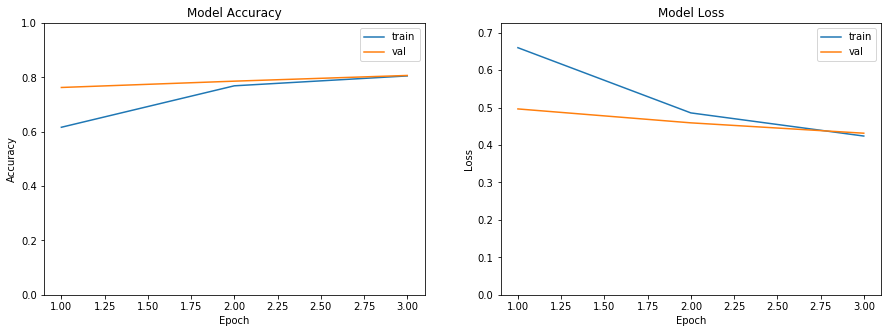

In [48]:
def plot_model_history(model_history):

    fig, axs = plt.subplots(1,2,figsize=(15,5))

    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[0].set_ylim([0,1.0])

    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    axs[1].set_ylim([0,1.1*max(np.array(model_history.history['loss']).max(), np.array(model_history.history['val_loss']).max())])
    
    plt.show()
    
plot_model_history(model_info)

We get a training and validation accuracy of about 80%, and a training and validation cross-entropy loss of about 43%. Doesn't seem to be overfitted, and is a good starting point for improvement.